# Method 4: MTL with multiple heads

In [161]:
import test
import importlib
importlib.reload(test)
from test import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [5]:
fun()

Hello World


### Initializing random multi-task data

In [171]:
# generate random data vector of dim 10
n = 100
dim = 10
# Task 1: 3 classes {0, 1, 2}
x_t1 = torch.rand(n, dim)
y_t1 = (x_t1.sum(dim=1)/3).floor()[:,None]

# Task 2: 2 classes {0, 1}
x_t2 = torch.rand(n, dim)
y_t2 = (x_t2.mean(dim=1) * 2).floor()[:,None]


assert y_t1.shape == (n,1) and y_t2.shape == (n,1), "y_t1 and y_t2 should be column vectors"
# wrap into DataLoader
train_dataloader = DataLoader((x_t1,y_t1), batch_size=50, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)




In [172]:
x, y = next(iter(train_dataloader))

RuntimeError: stack expects each tensor to be equal size, but got [100, 10] at entry 0 and [100, 1] at entry 1

In [166]:
y_t1.shape, y_t1

(torch.Size([100]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
         1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         2., 0., 1., 1., 1., 2., 1., 2., 1., 0., 1., 1., 1., 2., 1., 1., 1., 1.,
         1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 2.]))

In [165]:
y_t2.shape, y_t2

(torch.Size([100]),
 tensor([1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
         1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
         0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
         0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
         0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
         1., 1., 0., 1., 0., 0., 0., 1., 0., 1.]))

### MTL mutli-head network

In [47]:
# when we have multiple tasks performed on the same input data
class MTL(nn.Module):
    def __init__(self, dim, h_dim, t1_out, t2_out):
        super().__init__()
        # joint hidden layers
        self.BERT = nn.Linear(dim, h_dim)

        # task-specific classification heads
        self.cf_t1 = nn.Linear(h_dim, t1_out)
        self.cf_t2 = nn.Linear(h_dim, t2_out)

    def forward(self, x):
        # joint hidden state
        h = F.relu(self.BERT(x))
        # task 1
        p_t1 = F.softmax(self.cf_t1(h), dim=1)
        # task 2
        p_t2 = F.softmax(self.cf_t2(h), dim=1)
    
        return [p_t1, p_t2]

In [50]:
# when we have multiple tasks performed on different input data
class MTL(nn.Module):
    '''
    returns class probabilities for each task
    '''
    def __init__(self, dim, h_dim, t1_out, t2_out):
        super().__init__()
        # joint hidden layers
        self.BERT = nn.Linear(dim, h_dim)

        # task-specific classification heads
        self.cf_t1 = nn.Linear(h_dim, t1_out)
        self.cf_t2 = nn.Linear(h_dim, t2_out)

    def forward(self, x, task_num=1):
        # joint hidden state
        h = F.relu(self.BERT(x))
        # task 1
        if task_num == 1:
            p_t1 = F.softmax(self.cf_t1(h), dim=1)
            return p_t1
        # task 2
        elif task_num == 2:
            p_t2 = F.softmax(self.cf_t2(h), dim=1)
            return p_t2
        else:
            print("Invalid task number")
            return None

In [143]:
model = MTL(dim, 10, 3, 2)

In [111]:
model.forward(x_t1[0:2], task_num=1)

tensor([[0.4525, 0.3207, 0.2268],
        [0.4499, 0.2992, 0.2509]], grad_fn=<SoftmaxBackward0>)

In [112]:
# cross-entropy loss accepts logits as input and either class label or class probabilities vecoter as target: loss(input, target)
# has an internal softmax
# targets are class indices so {0,1} is valid and {-1,1} is not valid
loss_fn = nn.CrossEntropyLoss()

### Training procedure

In [145]:
model = MTL(dim, 10, 3, 2)
# optimizer: RMSprop as in the paper
# alpha: smoothing constant (default: 0.99)
# eps: term added to the denominator to improve numerical stability (default: 1e-8)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

# loss function: cross-entropy
loss_fn = nn.CrossEntropyLoss()

epochs = 10000

for epoch in range(1, epochs+1):
    #mini_batches = 
    #for mini_batch in mini_batches:
    # zero the parameter gradients
    optimizer.zero_grad()

    # task 1
    # get class probabilities
    p_t1 = model.forward(x_t1, task_num=1)
    # make predictions
    # y_pred_t1 = p_t1.argmax(dim=1).float()
    # compute loss
    loss_t1 = loss_fn(p_t1,y_t1.long())

    # task 2
    # get class probabilities
    p_t2 = model.forward(x_t2, task_num=2)
    # compute loss
    loss_t2 = loss_fn(p_t2,y_t2.long())

    # total loss
    loss = loss_t1 + loss_t2

    #loss = Variable(loss, requires_grad = True)

    # backpropagate
    loss.backward()
    # update parameters
    optimizer.step()

    # print statistics
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{epochs} | Loss: {loss.item():.4f}")




    

Epoch 1000/10000 | Loss: 1.1469
Epoch 2000/10000 | Loss: 1.0485
Epoch 3000/10000 | Loss: 1.0248
Epoch 4000/10000 | Loss: 1.0181
Epoch 5000/10000 | Loss: 1.0158
Epoch 6000/10000 | Loss: 1.0150
Epoch 7000/10000 | Loss: 1.0148
Epoch 8000/10000 | Loss: 1.0147
Epoch 9000/10000 | Loss: 1.0147
Epoch 10000/10000 | Loss: 1.0147


### Evalutation

In [160]:
# evaluate model accuracy
# predict classes
y_pred_t1 = model(x_t1, task_num=1).argmax(dim=1).float()
y_pred_t2 = model(x_t2, task_num=2).argmax(dim=1).float()

print('===============================')
# task 1
acc_t1 = (y_pred_t1 == y_t1).sum().item()/n
print(f"Task 1 train accuracy: {acc_t1:.4f}")
# task 2
acc_t2 = (y_pred_t2 == y_t2).sum().item()/n
print(f"Task 2 train accuracy: {acc_t2:.4f}")
print('===============================')

Task 1 train accuracy: 0.8500
Task 2 train accuracy: 1.0000


### Confusion matrix

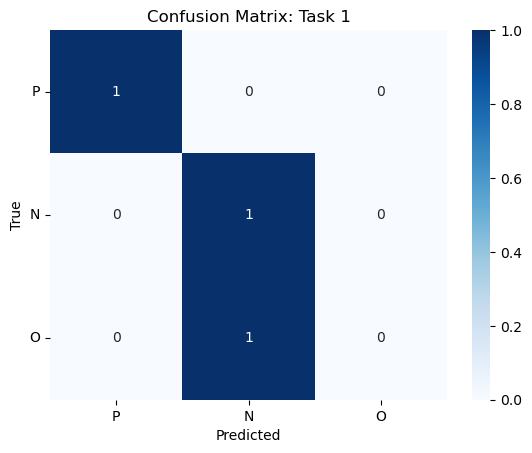

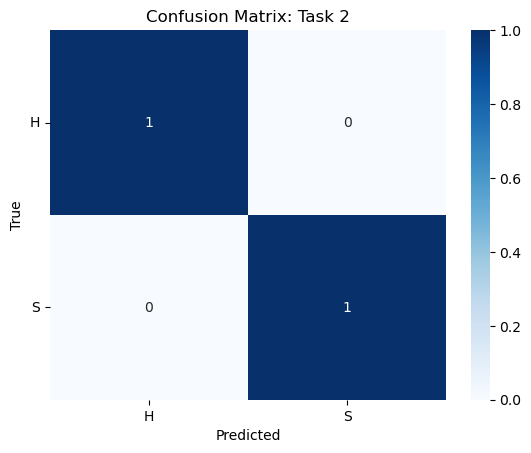

In [157]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_conf_matrix(y, y_pred, targets, task_num=1):
    cm = confusion_matrix(y, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=targets.values(), yticklabels=targets.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: Task {task_num}')
    plt.yticks(rotation=0)
    plt.show()

targets_t1 = {0: 'P', 1: 'N', 2: 'O'}
targets_t2 = {0: 'H', 1: 'S'}

plot_conf_matrix(y_t1, y_pred_t1, targets_t1, task_num=1)
plot_conf_matrix(y_t2, y_pred_t2, targets_t2, task_num=2)